# B-tree Implementation for Key-value Store
### B-Tree Implementation in a Key-value Store, with Numeric or Non-numeric Unique Keys, Range Look-Up, and Functional and Performance Tests

Our objective is to create a key-value store that is more efficient for range queries when compared to a key-value store reliant on the built-in dictionary implementation.  We will take the following steps:
1. Import base class BTree, implemented in btree.py.  Its base class, Node, is implemented in node.py
2. Implement KVStore with the following:
    - inheritance from `BTree`
    - `split_threshold` attribute with default of 2, which determines the size (lengths of lists for keys and values) of any given node
    - getter and setter methods to add bracket syntax (i.e., `kv_instance[key] = value`, etc.); note that value overwrite functionality for unique keys is inherited from the `Node` class via the `BTree` class
    -  `in` operator or `__contains__()` method (i.e., `key in kv_instance`)
    - `range_query()` method for both numeric OR string keys (i.e., `kv_instance.range_query(range_start, range_end`) to return all values for keys in given range
    - `find_min_key()` and `find_max_key()` methods
    - `items()`, `keys()`, and `values` methods analogous to the those of the built-in dictionary class
    - `save()` and `load()` to/from pickle files
    - `__iter__()` and `__next__()` for analogous iterator functionality of the built-in dictionary class
3. Test of the above for numeric keys
4. Test for string keys, as indicated
5. Extend built-in `dict` class with `range_query` method for comparison in `DictKVStore` class
6. Confirm `KVStore` and `DictKVStore` obtain matching results for inserts/retrievals/range queries
7. Random tests of functionality of `KVStore` with `DictKVStore` as baseline
8. Speed tests of `KVStore` vs `DictKVStore`

In [1]:
# To structure code automatically
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import B-Tree Implementation

In [2]:
# Base class BTree from btree.py, which derived class of Node class from node.py
from btree import BTree

<IPython.core.display.Javascript object>

### KVStore Implementation

In [3]:
import pickle as pkl


class KVStore(BTree):
    def __init__(self, split_threshold=2):
        super().__init__(split_threshold)

    def __getitem__(self, key):
        return self.get_value(key)

    def __setitem__(self, key, value):
        self.add(key, value)

    def __contains__(self, key):
        return self.contains(key)

    def __iter__(self):
        if self.size == 0:
            self._iter_num = None
        else:
            self._iter_num = 0
        return self

    def __next__(self):
        if self._iter_num is None:
            raise StopIteration
        if self._iter_num == self.size:
            raise StopIteration
        else:
            ret = self.keys()[self._iter_num]
            self._iter_num += 1
            return ret

    def _items(self, current_node):
        results = []
        for i, key in enumerate(current_node.keys):
            results += [(key, current_node.values[i])]
        if not current_node.is_leaf():
            for j, child in enumerate(current_node.children):
                results += self._items(child)
        return sorted(results, key=lambda x: x[0])

    def items(self):
        return self._items(self.root)

    def keys(self):
        items = self._items(self.root)
        return [x[0] for x in items]

    def values(self):
        items = self._items(self.root)
        return [x[1] for x in items]

    def _find_min_key(self, current_node):
        if current_node.is_leaf():
            return current_node.keys[0]
        if current_node.keys[0] < current_node.children[0].keys[0]:
            return current_node.keys[0]
        else:
            return self._find_min_key(current_node.children[0])

    def find_min_key(self):
        return self._find_min_key(self.root)

    def _find_max_key(self, current_node):
        if current_node.is_leaf():
            return current_node.keys[-1]
        if current_node.keys[-1] > current_node.children[-1].keys[-1]:
            return current_node.keys[-1]
        else:
            return self._find_max_key(current_node.children[-1])

    def find_max_key(self):
        return self._find_max_key(self.root)

    def _range_query(
        self, current_node, range_start, range_end, min_key, max_key,
    ):
        if range_end < min_key or range_start > max_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(
                    child, range_start, range_end, new_min_key, new_max_key
                )
        return results

    def range_query(self, range_start, range_end):
        key_numeric = str(range_start).isnumeric()
        if key_numeric:
            min_key = float("-inf")
            max_key = float("inf")
        else:
            str_factor = len(range_end) + 1
            min_key = ""
            max_key = "z" * str_factor

        return self._range_query(self.root, range_start, range_end, min_key, max_key)

    def save(self, filename):
        with open(f"{filename}.pkl", "wb") as f:
            pkl.dump(self, f)

    def load(self, filename):
        with open(f"{filename}.pkl", "rb") as f:
            return pkl.load(f)

<IPython.core.display.Javascript object>

### Testing KVStore for Numeric Keys

In [4]:
# Test for split_threshold
print("Testing Split Threshold")
kv = KVStore()
assert kv.split_threshold == 2, "The split threshold is not equal to 2."

# Test for initial key, value add
print("Testing Initial Add")
keys = list(range(0, 10))

for i in keys:
    kv.add(i, i)
for i in keys:
    assert kv.get_value(i) == i, "Expected value not retrieved."

# Test for updated value add
print("Testing Value Overwrite")
for i in keys:
    kv.add(i, i + 1)

for i in keys:
    assert kv.get_value(i) == i + 1, "Expected value not retrieved."

# Test for bracket syntax assignment
print("Testing Assignment with Bracket Syntax")
for i in keys:
    kv[i] = i
for i in keys:
    assert kv.get_value(i) == i, "Expected value not retrieved."


# Test for value overwrite with bracket syntax
print("Testing Value Overwrite with Bracket Syntax")
for i in keys:
    kv[i] = i + 1
for i in keys:
    assert kv.get_value(i) == i + 1, "Expected value not retrieved."

# Re-test bracket syntax retrieval with updated values
print("Testing Retrieval with Bracket Syntax after Value Overwrite")
for i in keys:
    assert kv[i] == i + 1, "Expected value not retrieved."

# Testing bracket syntax for contains key
print("Testing the In Operator")
for i in keys:
    assert kv.contains(i), "Expected value not retrieved."
not_keys = [i - 100 for i in keys]
for not_i in not_keys:
    assert not kv.contains(not_i), "Expected value not retrieved."

# Testing range_query
print("Testing Range Query")
sub_keys = keys[2:9]
for i in keys:
    kv[i] = i
for i in sub_keys:
    assert i in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."
for i in [i for i in keys if i not in sub_keys]:
    assert i not in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."

# Testing items retrieval
print("Testing Items Retrieval")
for i in keys:
    kv[i] = i + 1
for i in keys:
    assert kv.items()[i] == (i, i + 1), "Expected items not retrieved."

# Testing keys retrieval
print("Testing Keys Retrieval")
for i in keys:
    assert kv.keys()[i] == i, "Expected items not retrieved."

# Testing values retrieval
print("Testing Values Retrieval")
for i in keys:
    assert kv.values()[i] == i + 1, "Expected items not retrieved."

# Testing save and load
print("Testing Save and Load")
kv.save("kv")
kv_loaded = kv.load("kv")
assert kv.items() == kv_loaded.items(), "Saved index does not match original."

# Testing iterator
print("Testing Iterator")
for i in kv:
    assert i == keys[i], f"Expected next {key} not retrieved."

Testing Split Threshold
Testing Initial Add
Testing Value Overwrite
Testing Assignment with Bracket Syntax
Testing Value Overwrite with Bracket Syntax
Testing Retrieval with Bracket Syntax after Value Overwrite
Testing the In Operator
Testing Range Query
Testing Items Retrieval
Testing Keys Retrieval
Testing Values Retrieval
Testing Save and Load
Testing Iterator


<IPython.core.display.Javascript object>

### Testing KVStore for String Keys

In [5]:
kv = KVStore()
keys = "abcdefghijk"
for i in keys:
    kv[i] = i

# Testing bracket syntax for contains key
print("Testing the In Operator")
for i in keys:
    assert kv.contains(i), "Expected value not retrieved"
not_keys = ["lmnopqrstuvwxyz"]
for not_i in not_keys:
    assert not kv.contains(not_i), "Expected value not retrieved"

# Testing range_query
print("Testing Range Query")
sub_keys = keys[2:9]
for i in keys:
    kv[i] = i
for i in sub_keys:
    assert i in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."
for i in [i for i in keys if i not in sub_keys]:
    assert i not in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."

# Testing items retrieval
print("Testing Items Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.items()[i] == (keys[i], keys[i + 1]), "Expected value not retrieved."

# Testing keys retrieval
print("Testing Keys Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.keys()[i] == keys[i], "Expected value not retrieved."

# Testing values retrieval
print("Testing Values Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.values()[i] == keys[i + 1], "Expected value not retrieved."

# Testing iterator
print("Testing Iterator")
for i, key in enumerate(kv):
    assert key == keys[i], f"Expected next {key} not retrieved."

Testing the In Operator
Testing Range Query
Testing Items Retrieval
Testing Keys Retrieval
Testing Values Retrieval
Testing Iterator


<IPython.core.display.Javascript object>

### Comparing Results for KVStore Extending Built-in Dictionary Class and New KVStore

#### Defining `range_query` Method Extending Built-in Dictionary Class

In [6]:
class DictKVStore(dict):
    def range_query(self, range_start, range_end):
        results = []
        for key in self.keys():
            if range_start <= key <= range_end:
                results.append(self[key])
        return results

<IPython.core.display.Javascript object>

#### Comparing `range_query` Results of Both KVStores

In [7]:
# For numeric keys
print("Testing for Matching Results for Numeric Keys")
dict_kv = DictKVStore()
new_kv = KVStore()

for i in range(10):
    dict_kv[i] = i
    new_kv[i] = i

ranges = [(0, 5), (1, 5), (6, 7), (9, 9), (3, 8)]

for range_start, range_end in ranges:
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, "Results do not match for the different KVStores"

# For string keys
print("Testing for Matching Results for String Keys")
dict_kv = DictKVStore()
new_kv = KVStore()

for i in "efghijklmnopq":
    dict_kv[i] = i
    new_kv[i] = i

ranges = [("a", "z"), ("c", "l"), ("m", "m"), ("e", "q"), ("w", "z")]

for range_start, range_end in ranges:
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, "Results do not match for the different KVStores"

# Testing items retrieval
print("Testing Items Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.items()[i] == (keys[i], keys[i + 1]), "Expected value not retrieved."

# Testing keys retrieval
print("Testing Keys Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.keys()[i] == keys[i], "Expected value not retrieved."

# Testing values retrieval
print("Testing Values Retrieval")
for i in range(10):
    kv[keys[i]] = keys[i + 1]
for i in range(10):
    assert kv.values()[i] == keys[i + 1], "Expected value not retrieved."

Testing for Matching Results for Numeric Keys
Testing for Matching Results for String Keys
Testing Items Retrieval
Testing Keys Retrieval
Testing Values Retrieval


<IPython.core.display.Javascript object>

### Random Tests

#### Random Tests for Numeric Keys

In [8]:
import random

num_inserts = 10
num_range_queries = 10
num_contains = 10

dict_kv = DictKVStore()
new_kv = KVStore()

print("Testing Insertion")
for _ in range(num_inserts):
    key = random.randint(0, 100)
    value = random.randint(0, 1000000)
    dict_kv[key] = value
    new_kv[key] = value

print("Testing Length")
assert len(dict_kv) == len(
    new_kv
), f"The legths do not match: {len(dict_kv)} and {len(new_kv)}."

print("Testing Values")
for key in dict_kv:
    assert (
        dict_kv[key] == new_kv[key]
    ), f"Wrong value for key {key}.  Expected {dict_kv[key]} but found {new_kv[key]}."

print("Testing in Operator")
for _ in range(num_contains):
    key = random.randint(0, 100)
    assert (key in dict_kv) == (key in new_kv)

print("Testing Range Query")
for _ in range(num_range_queries):
    range_start = random.randint(0, 100)
    range_end = random.randint(range_start, 100)
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, f"The results for key {key} do not match."

print("Testing Items Retrieval")
assert sorted(dict_kv.items()) == new_kv.items(), "Retrieved items do not match."

print("Testing Keys Retrieval")
assert sorted(dict_kv.keys()) == new_kv.keys(), "Retrieved keys do not match."

print("Testing Values Retrieval")
assert sorted(dict_kv.values()) == sorted(
    new_kv.values()
), "Retrieved values do not match."

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Query
Testing Items Retrieval
Testing Keys Retrieval
Testing Values Retrieval


<IPython.core.display.Javascript object>

#### Random Tests for String Keys

In [9]:
letters = sorted(
    [char for char in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"]
)

num_inserts = 10
num_range_queries = 10
num_contains = 10

dict_kv = DictKVStore()
new_kv = KVStore()

print("Testing Insertion")
for _ in range(num_inserts):
    key = letters[random.randint(0, len(letters) - 1)]
    value = letters[random.randint(0, len(letters) - 1)]
    dict_kv[key] = value
    new_kv[key] = value

print("Testing Length")
assert len(dict_kv) == len(
    new_kv
), f"The legths do not match: {len(dict_kv)} and {len(new_kv)}."

print("Testing Values")
for key in dict_kv:
    assert (
        dict_kv[key] == new_kv[key]
    ), f"Wrong value for key {key}.  Expected {dict_kv[key]} but found {new_kv[key]}."

print("Testing in Operator")
for _ in range(num_contains):
    key = letters[random.randint(0, len(letters) - 1)]
    assert (key in dict_kv) == (key in new_kv)

print("Testing Range Query")
for _ in range(num_range_queries):
    range_start_index = random.randint(0, len(letters) - 1)
    range_start = letters[range_start_index]
    range_end_index = random.randint(range_start_index, len(letters) - 1)
    range_end = letters[range_end_index]
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, f"The results for key {key} do not match."

print("Testing Items Retrieval")
assert sorted(dict_kv.items()) == new_kv.items(), "Retrieved items do not match."

print("Testing Keys Retrieval")
assert sorted(dict_kv.keys()) == new_kv.keys(), "Retrieved keys do not match."

print("Testing Values Retrieval")
assert sorted(dict_kv.values()) == sorted(
    new_kv.values()
), "Retrieved values do not match."

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Query
Testing Items Retrieval
Testing Keys Retrieval
Testing Values Retrieval


<IPython.core.display.Javascript object>

## Performance Testing
- To illustrate the process of generating the test data, we will create separate csv files for the entries and the query ranges.  This step could alternatively be handled in memory for the current example.
- Note that re-running the immediate cell below will simply overwrite the csv files with the same results as random.seed() is set and `'w'` is indicated (i.e., versus `'a'` for append) in the `open()` call of the context manager.  However, the speed test results will naturally vary with repeated runs.
- The length of both key-value stores will likely be shorter than the 100,000 entries created, due to overwriting values for duplicate keys that are generated randomly in the entries.

### Creating Test Entries and Query Ranges

In [10]:
import csv

random.seed(42)

# Creating a csv file of the keys and values of entries
with open("entries.csv", "w", newline="") as f:
    writer = csv.writer(f)
    header = ["key", "value"]
    writer.writerow(header)
    for i in range(0, 100000):
        key = random.randint(0, 200000)
        value = random.randint(0, 200000)
        row = [key, value]
        writer.writerow(row)

# Creating a csv file of the query range sizes, range_starts, range_ends
with open("queries.csv", "w", newline="") as f:
    writer = csv.writer(f)
    header = ["query_size", "range_start", "range_end"]
    writer.writerow(header)
    for i in range(1000, 11000, 10):
        increment = i
        range_start = random.randint(0, 90000)
        range_end = range_start + i
        row = [increment, range_start, range_end]
        writer.writerow(row)

<IPython.core.display.Javascript object>

### Running the Speed Tests
- Some queries have runtime of 0 for `new_kv` which throws an error for calculating the runtime ratio.
- So, we will exlude those queries from the runtime ratios, but collect them in a separate dictionary.
- To be fair in our comparison, we will also create a dictionary of any queries for which `dict_kv` has runtimes of 0, as the calculation of runtime ratio would result in 0 and not show if `new_kv` was actually slower than `dict_kv` for the range query in those instances.

In [11]:
import time

# Creating kv stores
dict_kv = DictKVStore()
new_kv = KVStore()

with open("entries.csv") as f:
    reader = csv.reader(f)
    rows = list(reader)
    for row in rows[1:]:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        new_kv[key] = value

# Comparing Performance on range queries
time_ratios = (
    {}
)  # Dict to collect query size keys with runtime ratios (dict_kv/new_kv) values
times_kv_zero = (
    {}
)  # Dict to collect query size keys with runtimes tuples (dict_kv_time, new_kv_time)
times_dict_zero = (
    {}
)  # Dict to collect query size keys with runtimes tuples (dict_kv_time, new_kv_time)

with open("queries.csv") as f:
    reader = csv.reader(f)
    rows = list(reader)
    for i, row in enumerate(rows[1:]):
        range_start = int(row[1])
        range_end = int(row[2])

        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        dict_kv_time = end - start

        start = time.time()
        new_kv.range_query(range_start, range_end)
        end = time.time()
        new_kv_time = end - start

        if new_kv_time > 0:
            time_ratios[row[0]] = dict_kv_time / new_kv_time
        if new_kv_time == 0:
            times_kv_zero[row[0]] = (dict_kv_time, new_kv_time)
        if dict_kv_time == 0:
            dict_kv_times[row[0]] = (dict_kv_time, new_kv_time)

<IPython.core.display.Javascript object>

### Visualizing Speed Test Results

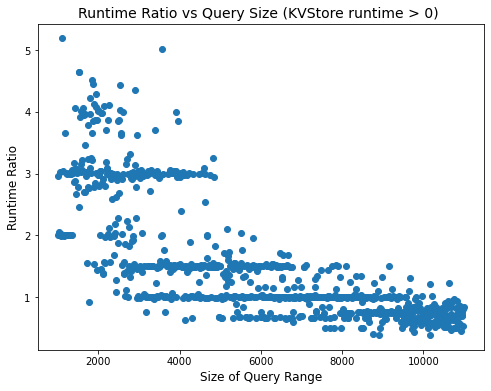

<IPython.core.display.Javascript object>

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Runtime Ratio vs Query Size (KVStore runtime > 0) ", fontsize=14)
plt.scatter([int(key) for key in time_ratios.keys()], time_ratios.values())
plt.xlabel("Size of Query Range", fontsize=12)
plt.ylabel("Runtime Ratio", fontsize=12)
# plt.ylim(
#     0, 6
# )  # plt.ylm line can be commented out/uncommented depending on presence of upper-end outliers for runtime ratio;
# it helps visualization by excluding upper-end outliers.
plt.show()

#### Observations:
- For query range sizes of up to ~4500 potential results, KVStore typically outperforms the range query implementing the built-in dictionary, as much as ~6 times faster, and frequently 1.5 to 3 times faster.
- As the query size increases further, the KVStore degrades from either on par with or even slower than the built-in dictionary.
- Let us check the queries for which one of the key-value stores had a runtime of 0.

There are 0 queries for which runtime of DictKVStore = 0.

There are 19 queries for which runtime of KVStore = 0.



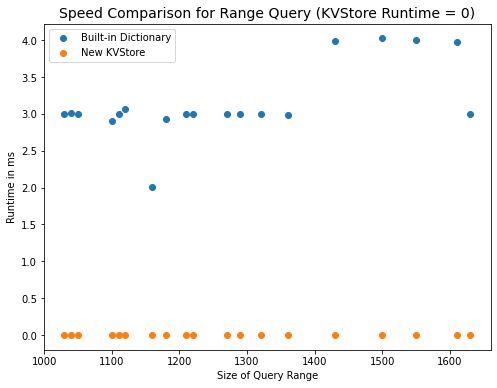

<IPython.core.display.Javascript object>

In [13]:
print(
    f"There are {len(times_dict_zero)} queries for which runtime of DictKVStore = 0.\n"
)
print(f"There are {len(times_kv_zero)} queries for which runtime of KVStore = 0.\n")

plt.figure(figsize=(8, 6))
plt.title("Speed Comparison for Range Query (KVStore Runtime = 0)", fontsize=14)
plt.scatter(
    [int(key) for key in times_kv_zero.keys()],
    [value[0] * 1000 for value in times_kv_zero.values()],
    label="Built-in Dictionary",
)
plt.scatter(
    [int(key) for key in times_kv_zero.keys()],
    [value[1] * 1000 for value in times_kv_zero.values()],
    label="New KVStore",
)
plt.xlabel("Size of Query Range")
plt.ylabel("Runtime in ms")
plt.legend()
plt.show()

#### Observations:
- There were only a handful of queries for which the runtime was zero for `new_kv` and none for `dict_kv`.  
- We can see that KVStore outperformed the built-in dictionary for all of these range queries.

## Conclusion:
Implementing a key-value store based on B-tree implementation allows for range queries, which are not avaible as a method of the built-in Python dictionary type.  Similar functionality can be achieved by extending the built-in dictionary class.  However, with query range sizes of up to ~4500 potential results, the B-tree implementation outperformed the built-in version, which is built using hash tables.  Above that size, the performance of the B-tree-based key-value store degraded to at par with, then below that of the built-in implementation, suggesting consideration of use case query size to determine the preferred approach.

An additional consideration is that built-in Python dictionaries allow for mixing key data types, as long as they are hashable.  The KVStore class presented here allows for either numeric or string types, but not both.